In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)


# Differential Photometry Preview  

In [2]:
import vso.util
import vso.data

OBJ_NAME='SZ Lyn'
SESSION_TAG='2025/20250225'
# OBJ_NAME='RZ Lyr'
# SESSION_TAG='20240827'
IMAGE_ROOT = '/srv/public/img'
WORK_ROOT = '/srv/public'

session = vso.util.Session(tag=SESSION_TAG, name=OBJ_NAME)
layout = vso.util.WorkLayout(WORK_ROOT)
session_layout = layout.get_session(session)
settings = vso.util.Settings(session_layout.settings_file_path)

In [3]:
from astropy.table import QTable
tr = QTable.read(session_layout.root_dir / "Tr_B_V.ecsv")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as sst

var = 'Tab'
var_err = var + '_err'

lr = sst.linregress(tr['airmass'], tr[var])
line = np.array([np.min(tr['airmass']), np.max(tr['airmass'])])
res = tr[var] - (tr['airmass'] * lr.slope + lr.intercept)
res_std = np.std(res)
dev_lim = 2

fltr = np.abs(res) < dev_lim*res_std
#fltr = np.abs(tr[var_err]) < np.percentile(tr[var_err], 75)

lr1 = sst.linregress(tr['airmass'][fltr], tr[var][fltr])
res1 = tr[var][fltr] - (tr['airmass'][fltr] * lr1.slope + lr1.intercept)
res_std_1 = np.std(res1)
#lr.stderr, lr1.stderr


In [5]:

def regr(lim):
    fltr = np.abs(res) < lim*res_std
    lrn = sst.linregress(tr['airmass'][fltr], tr[var][fltr])
    return lrn.slope, lrn.stderr, lrn.intercept, lrn.intercept_stderr

np.vectorize(regr)(np.linspace(.25, 2.0, 8))

(array([ 0.2462789 ,  0.17977895,  0.09478914, -0.07191326, -0.11670562,
        -0.18207073,  0.08635432,  0.04442993]),
 array([0.05680484, 0.10174428, 0.11681403, 0.12792442, 0.13945294,
        0.1529354 , 0.16838239, 0.174659  ]),
 array([0.94812518, 1.01815923, 1.11067219, 1.27817655, 1.31937717,
        1.39106239, 1.10595134, 1.14835305]),
 array([0.05932179, 0.10599782, 0.12170129, 0.13375342, 0.14575587,
        0.15954211, 0.17581552, 0.18236642]))

In [6]:
sst.normaltest(res), sst.normaltest(res1)

(NormaltestResult(statistic=np.float64(11.338300147196557), pvalue=np.float64(0.0034507969535093985)),
 NormaltestResult(statistic=np.float64(1.9793699674239331), pvalue=np.float64(0.3716937621706624)))

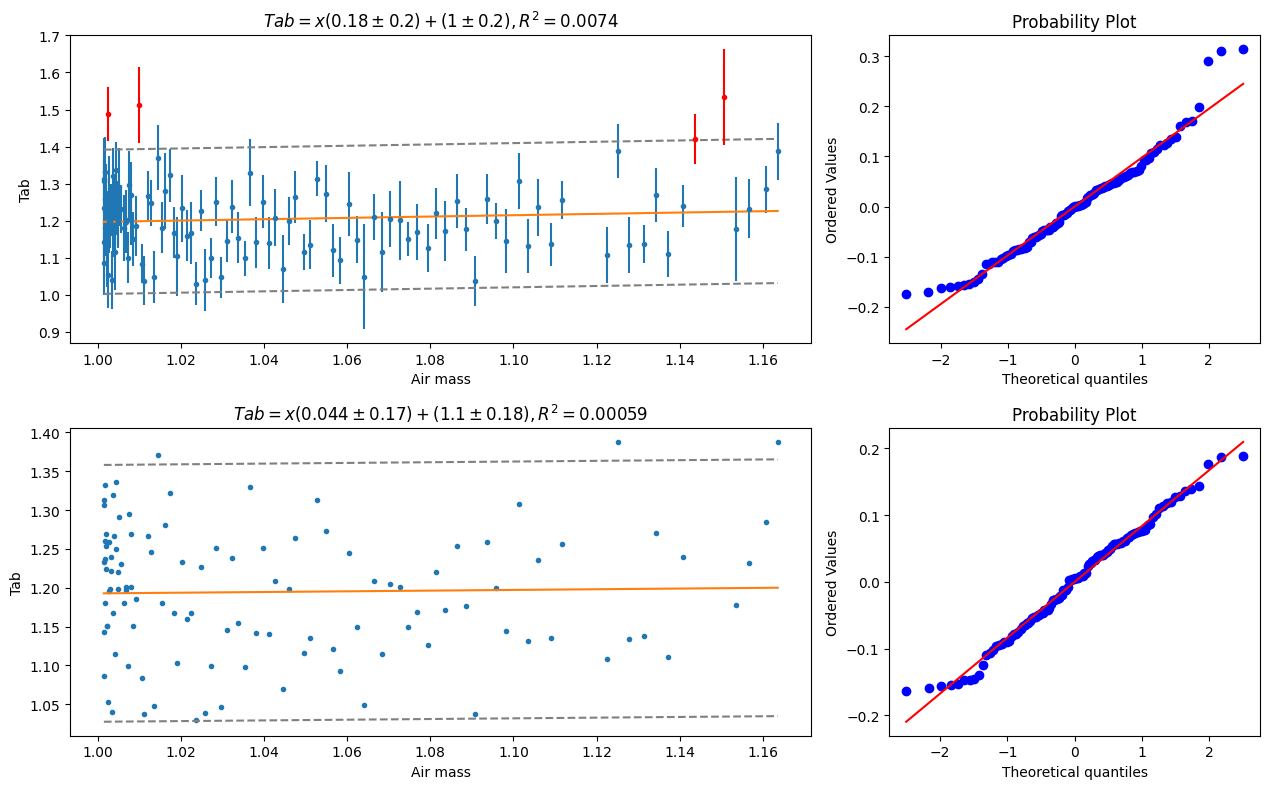

In [7]:

def reg_label(var, lr):
    return f'${{{var}}} = x ({{{lr.slope:.2g}}} \\pm {{{lr.stderr:.2g}}}) + ({{{lr.intercept:.2g}}} \\pm {{{lr.intercept_stderr:.2g}}}), R^2 = {{{lr.rvalue ** 2:.2g}}}$'

fig = plt.figure(figsize=(12.80, 8.00))
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1])
ax = fig.add_subplot(gs[0, 0])

#ax.plot(tr['airmass'][fltr], tr[var][fltr], '.')
ax.errorbar(tr['airmass'][fltr], tr[var][fltr], yerr=tr[var_err][fltr], fmt='.')
ax.plot(line, line * lr.slope + lr.intercept, "-")
ax.plot(line, line * lr.slope + lr.intercept + dev_lim*res_std, "--", color='grey')
ax.plot(line, line * lr.slope + lr.intercept - dev_lim*res_std, "--", color='grey')
#ax.plot(tr['airmass'][~fltr], tr[var][~fltr], '.', color='red')
ax.errorbar(tr['airmass'][~fltr], tr[var][~fltr], yerr=tr[var_err][~fltr], fmt='.', color='red')
ax.set_ylabel(var)
ax.set_xlabel('Air mass')
ax.set_title(reg_label(var, lr))

ax1 = fig.add_subplot(gs[0, 1])
# ax1.hist(res, bins=20)
sst.probplot(res, dist="norm", plot=ax1)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(tr['airmass'][fltr], tr[var][fltr], '.')
ax2.plot(line, line * lr1.slope + lr1.intercept, "-")
ax2.plot(line, line * lr1.slope + lr1.intercept + dev_lim*res_std_1, "--", color='grey')
ax2.plot(line, line * lr1.slope + lr1.intercept - dev_lim*res_std_1, "--", color='grey')
ax2.set_ylabel(var)
ax2.set_xlabel('Air mass')
ax2.set_title(reg_label(var, lr1))

ax3 = fig.add_subplot(gs[1, 1])
#ax3.hist(res1, bins=20)
sst.probplot(res1, dist="norm", plot=ax3)

plt.tight_layout()
plt.show()


In [8]:
# %matplotlib ipympl
# #fig = plt.figure(figsize=(8.00, 16.00))
# gs = fig.add_gridspec(1, 1)
# ax = fig.add_subplot(gs[0, 0], projection='3d')
# ax.scatter(tr['Ta'], tr['Tb'], tr['Tab'], marker='.')
# ax.set_xlabel('Ta')
# ax.set_ylabel('Tb')
# ax.set_zlabel('Tab')
# plt.show()


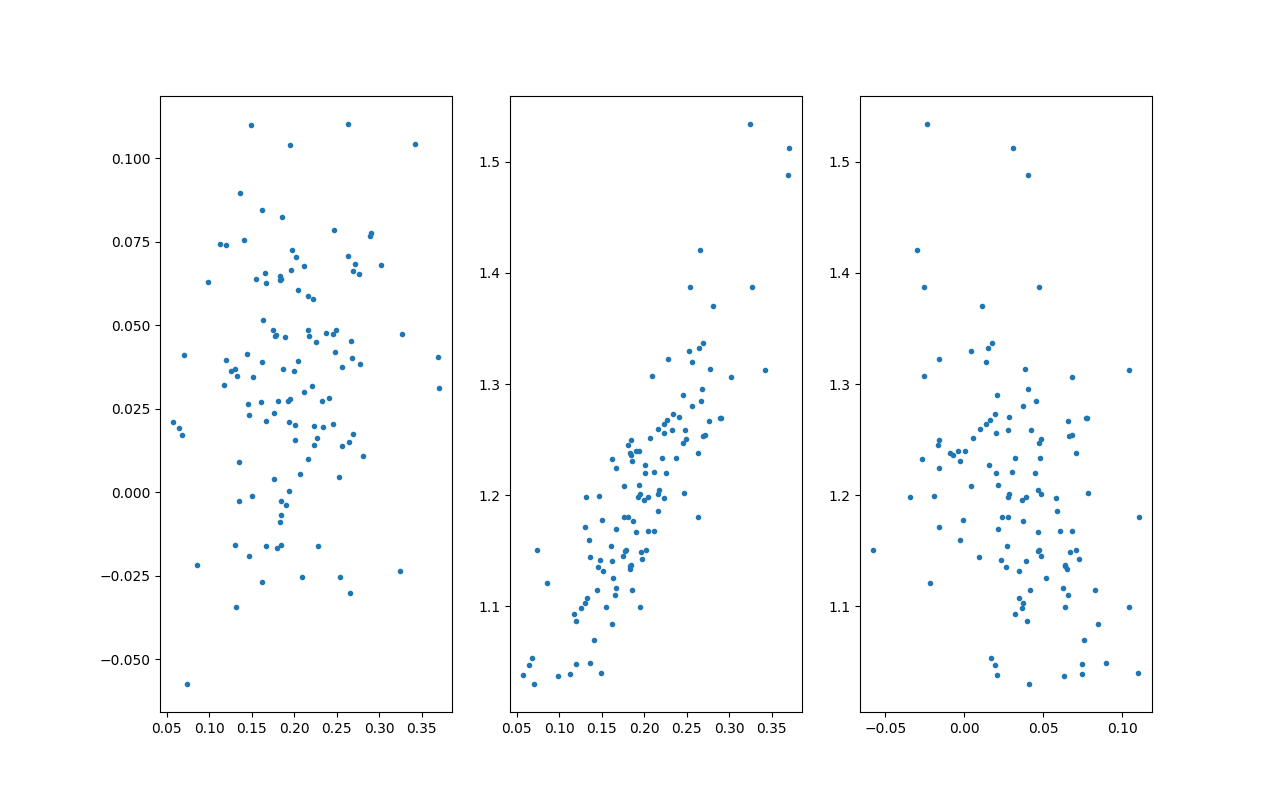

In [ ]:
fig = plt.figure(figsize=(12.80, 8.00))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(tr['Ta'], tr['Tb'], marker='.')
ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(tr['Ta'], tr['Tab'], marker='.')
ax2 = fig.add_subplot(gs[0, 2])
ax2.scatter(tr['Tb'], tr['Tab'], marker='.')
plt.show()


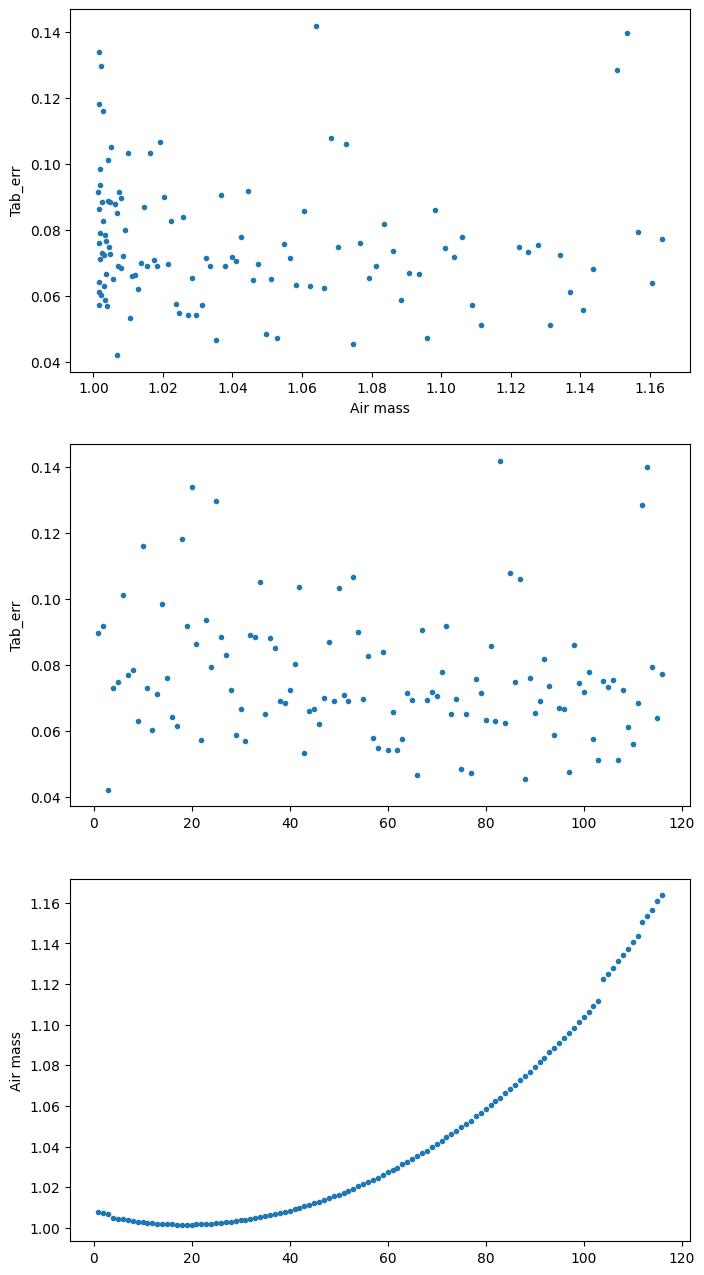

In [10]:
fig = plt.figure(figsize=(8.00, 16.00))
gs = fig.add_gridspec(3, 1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(tr['airmass'], tr[var_err], '.')
ax.set_ylabel(var_err)
ax.set_xlabel('Air mass')

ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(tr['id'], tr[var_err], '.')
ax1.set_ylabel(var_err)
#ax1.set_xlabel('Air mass')

ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(tr['id'], tr['airmass'], '.')
ax2.set_ylabel('Air mass')

plt.show()